In [1]:
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import Counter

import pandas as pd
import numpy as np

In [2]:
#settings
EPOCHS = 20
BATCH_SIZE = 256
CLASS_WEIGHT=[1, 1, 1]
HIDDEN_DIM=64
#
MAX_LEN = 400

# Data Upload

In [4]:
df = pd.read_csv('HateSpeechTurkish.csv', encoding="utf-8-sig")

In [5]:
#df = df.head(1000)

In [6]:
history = {'loss': [], 'f1': [], 'val_loss': [], 'val_f1': []}

In [7]:
main_result = {'model_name': [],
               'Accuracy': [], 'Precision': [], 'Recall': [] , 'F1': [],
               'Train_Time': [] , 'Infer_Time': []}

In [8]:
if df.isnull().values.any():
    print(df.isnull().sum())
    df.dropna(inplace=True)

row_id                      0
tweet                       0
etiket                     55
corrected_tweet             0
correct_normalize_tweet     0
dtype: int64


In [9]:
print("After drop null value:")
print(df.isnull().sum())

After drop null value:
row_id                     0
tweet                      0
etiket                     0
corrected_tweet            0
correct_normalize_tweet    0
dtype: int64


In [10]:
df['etiket'].value_counts()

etiket
hiçbiri      7667
nefret       2336
saldırgan     166
Name: count, dtype: int64

In [11]:
print("Original data class distribution:", Counter(df['etiket']))

Original data class distribution: Counter({'hiçbiri': 7667, 'nefret': 2336, 'saldırgan': 166})


In [12]:
label_mapping={
 'nefret':     0,
 'saldırgan':  1,
 'hiçbiri':    2,
}

In [13]:
y = df['etiket'].map(label_mapping)

In [14]:
x = df['correct_normalize_tweet']

# FT-TRW2V(FineTune turkish Word2Vec)

In [16]:
from gensim.models import KeyedVectors

path = "embedding/trmodel_finetune.kv"  # değiştir!
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)
emb_dim = w2v_model.vector_size

In [17]:
print(emb_dim)

400


# NLP

In [19]:
special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN = special_tokens
PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX = 0, 1, 2, 3

In [20]:
tokenized_sentences = [sentence.split() for sentence in x]
all_tokens = [token for sent in tokenized_sentences for token in sent]
vocab = special_tokens + sorted(set(all_tokens))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}


In [21]:
import numpy as np
import torch

embedding_matrix = np.zeros((len(word2idx), emb_dim))
for word, idx in word2idx.items():
    if word in w2v_model:
        embedding_matrix[idx] = w2v_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(emb_dim,))
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [22]:
def encode_sentence(sentence, word2idx, max_len):
    tokens = sentence.split()
    indices = [word2idx.get(w, UNK_IDX) for w in tokens]
    indices = [SOS_IDX] + indices + [EOS_IDX]
    if len(indices) < max_len:
        indices += [PAD_IDX] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices


encoded_data = [encode_sentence(sent, word2idx, MAX_LEN) for sent in x]


X = encoded_data

# Test train split

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)
print("x_train",len(X_train))
print("x_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))
print("Number of unique classes in y_test:",len(set(y_test)))

x_train 9152
x_test 1017
y_train 9152
y_test 1017
Number of unique classes in y_test: 3


In [25]:
src_tensor = torch.tensor(X_train, dtype=torch.long)
trg_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
src_tensor_test = torch.tensor(X_test, dtype=torch.long)
trg_tensor_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
sample = torch.tensor(X_test[10:11], dtype=torch.long).to(device)  # Sample for inferece time test

cuda


In [27]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(src_tensor, trg_tensor)
val_dataset = TensorDataset(src_tensor_test, trg_tensor_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# AdditiveAttention + FT-W2V

In [29]:
model_name='bahdanau_FT-W2V'

In [30]:
OUTPUT_DIM =len(set(y))

In [31]:
from transformer_model.attention import AdditiveAttention
from train.trainSeq2Seq import train_seq2seq_model



attention = AdditiveAttention(hidden_dim=HIDDEN_DIM)

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 0.8153, F1: 0.2898 | Val_Loss: 0.6519, Val_F1: 0.2881
Epoch 02 | Loss: 0.6415, F1: 0.2864 | Val_Loss: 0.6058, Val_F1: 0.2881
Epoch 03 | Loss: 0.6238, F1: 0.2864 | Val_Loss: 0.5978, Val_F1: 0.2881
Epoch 04 | Loss: 0.6188, F1: 0.2864 | Val_Loss: 0.5977, Val_F1: 0.2881
Epoch 05 | Loss: 0.6174, F1: 0.2864 | Val_Loss: 0.5974, Val_F1: 0.2881
Epoch 06 | Loss: 0.6147, F1: 0.2864 | Val_Loss: 0.5908, Val_F1: 0.2881
Epoch 07 | Loss: 0.6087, F1: 0.2864 | Val_Loss: 0.5853, Val_F1: 0.2881
Epoch 08 | Loss: 0.5989, F1: 0.2870 | Val_Loss: 0.5769, Val_F1: 0.2881
Epoch 09 | Loss: 0.5879, F1: 0.2899 | Val_Loss: 0.5649, Val_F1: 0.2912
Epoch 10 | Loss: 0.5720, F1: 0.3052 | Val_Loss: 0.5513, Val_F1: 0.2967
Epoch 11 | Loss: 0.5542, F1: 0.3364 | Val_Loss: 0.5400, Val_F1: 0.3555
Epoch 12 | Loss: 0.5366, F1: 0.3872 | Val_Loss: 0.5305, Val_F1: 0.4098
Epoch 13 | Loss: 0.5164, F1: 0.4329 | Val_Loss: 0.5192, Val_F1: 0.4098
Epoch 14 | Loss: 0.4928, F1: 0.4557 | Val_Loss: 0.5113, Val_F1: 0.4484
Epoch 

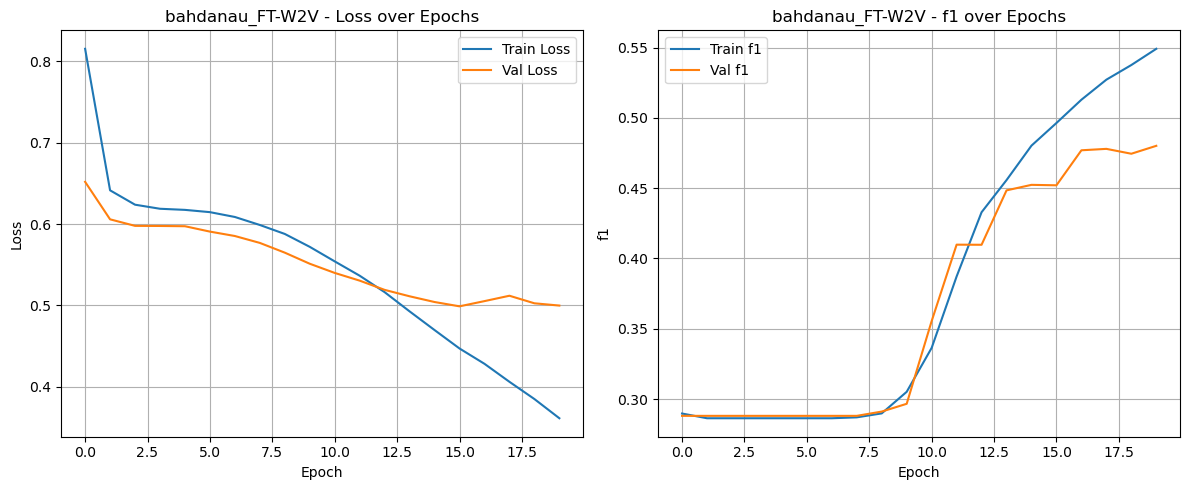

📈 Training history saved to: plots/saved/bahdanau_FT-W2V_plot.png


In [32]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - bahdanau_FT-W2V
Accuracy  : 0.8063
Precision : 0.4876
Recall    : 0.4754
F1 Score  : 0.4801


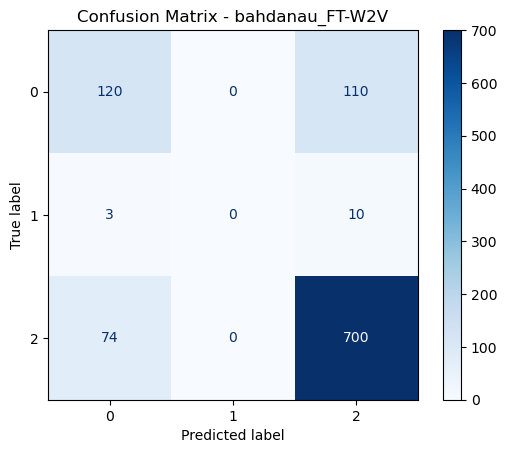

📌 Confusion matrix saved to: plots/saved/bahdanau_FT-W2V_csmtx.png


In [33]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [34]:
def test_inference(model,sample):
    start_infer = time.time()
    
    with torch.no_grad():
        output = model(sample)
        pred = output.argmax(dim=1).item()
        
    end_infer = time.time()
    
    infer_time = (end_infer - start_infer )* 1000
    
    print(f"\n🧠 Prediction for sample #10: Class {pred}")
    print(f"⚡ Inference Time for one sample : {infer_time:.2f} ms")
    return infer_time

In [35]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 3.00 ms


In [36]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

In [37]:
main_result

{'model_name': ['bahdanau_FT-W2V'],
 'Accuracy': [0.8062930186823992],
 'Precision': [0.4875985308076431],
 'Recall': [0.47537729843088794],
 'F1': [0.48011816364450216],
 'Train_Time': [33138.60368728638],
 'Infer_Time': [3.004789352416992]}

# AdditiveAttention + FreeEmbedding

In [39]:
model_name='bahdanau_FE'

In [40]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 0.8289, F1: 0.2907 | Val_Loss: 0.6472, Val_F1: 0.2881
Epoch 02 | Loss: 0.6374, F1: 0.2864 | Val_Loss: 0.6040, Val_F1: 0.2881
Epoch 03 | Loss: 0.6223, F1: 0.2864 | Val_Loss: 0.5977, Val_F1: 0.2881
Epoch 04 | Loss: 0.6174, F1: 0.2864 | Val_Loss: 0.5960, Val_F1: 0.2881
Epoch 05 | Loss: 0.6166, F1: 0.2864 | Val_Loss: 0.5946, Val_F1: 0.2881
Epoch 06 | Loss: 0.6130, F1: 0.2864 | Val_Loss: 0.5921, Val_F1: 0.2881
Epoch 07 | Loss: 0.6062, F1: 0.2864 | Val_Loss: 0.5906, Val_F1: 0.2881
Epoch 08 | Loss: 0.5991, F1: 0.2871 | Val_Loss: 0.5884, Val_F1: 0.2881
Epoch 09 | Loss: 0.5947, F1: 0.2918 | Val_Loss: 0.5876, Val_F1: 0.2881
Epoch 10 | Loss: 0.5871, F1: 0.3023 | Val_Loss: 0.5876, Val_F1: 0.3035
Epoch 11 | Loss: 0.5803, F1: 0.3193 | Val_Loss: 0.5861, Val_F1: 0.2959
Epoch 12 | Loss: 0.5731, F1: 0.3335 | Val_Loss: 0.5849, Val_F1: 0.3183
Epoch 13 | Loss: 0.5656, F1: 0.3493 | Val_Loss: 0.5838, Val_F1: 0.3244
Epoch 14 | Loss: 0.5577, F1: 0.3618 | Val_Loss: 0.5834, Val_F1: 0.3421
Epoch 

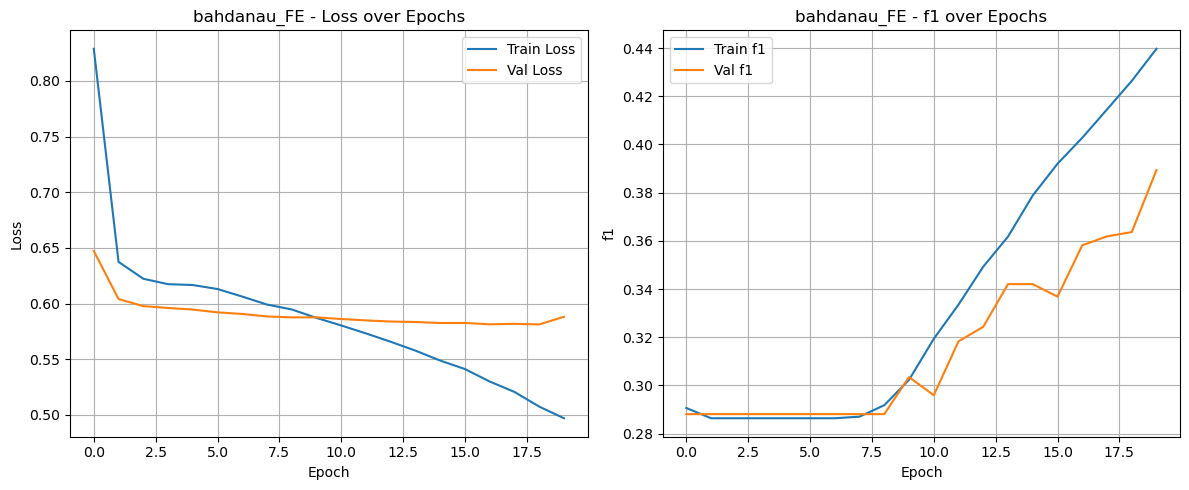

📈 Training history saved to: plots/saved/bahdanau_FE_plot.png


In [41]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - bahdanau_FE
Accuracy  : 0.7414
Precision : 0.4065
Recall    : 0.3869
F1 Score  : 0.3894


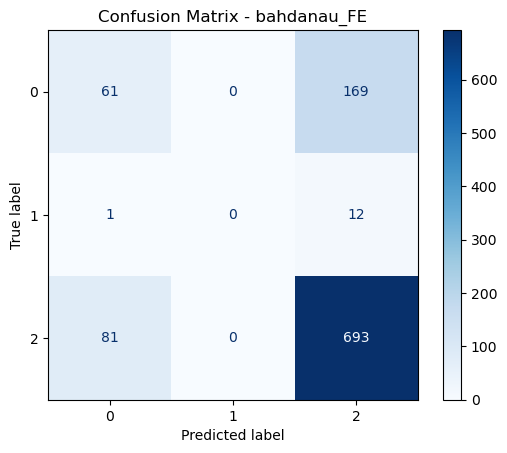

📌 Confusion matrix saved to: plots/saved/bahdanau_FE_csmtx.png


In [42]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [43]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 1.03 ms


In [44]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# DotProduct + FT-W2V

In [46]:
model_name='Luong_FT-W2V'

In [47]:
from transformer_model.attention import DotProductAttention
attention = DotProductAttention()

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 0.7970, F1: 0.3191 | Val_Loss: 0.6384, Val_F1: 0.2881
Epoch 02 | Loss: 0.6368, F1: 0.2864 | Val_Loss: 0.6029, Val_F1: 0.2881
Epoch 03 | Loss: 0.6215, F1: 0.2864 | Val_Loss: 0.5993, Val_F1: 0.2881
Epoch 04 | Loss: 0.6206, F1: 0.2864 | Val_Loss: 0.5971, Val_F1: 0.2881
Epoch 05 | Loss: 0.6189, F1: 0.2864 | Val_Loss: 0.5957, Val_F1: 0.2881
Epoch 06 | Loss: 0.6159, F1: 0.2864 | Val_Loss: 0.5940, Val_F1: 0.2881
Epoch 07 | Loss: 0.6122, F1: 0.2864 | Val_Loss: 0.5945, Val_F1: 0.2881
Epoch 08 | Loss: 0.6073, F1: 0.2867 | Val_Loss: 0.5872, Val_F1: 0.2881
Epoch 09 | Loss: 0.5996, F1: 0.2877 | Val_Loss: 0.5788, Val_F1: 0.2881
Epoch 10 | Loss: 0.5886, F1: 0.2985 | Val_Loss: 0.5668, Val_F1: 0.2939
Epoch 11 | Loss: 0.5724, F1: 0.3195 | Val_Loss: 0.5572, Val_F1: 0.3254
Epoch 12 | Loss: 0.5569, F1: 0.3555 | Val_Loss: 0.5417, Val_F1: 0.3602
Epoch 13 | Loss: 0.5351, F1: 0.3993 | Val_Loss: 0.5244, Val_F1: 0.3997
Epoch 14 | Loss: 0.5129, F1: 0.4309 | Val_Loss: 0.5089, Val_F1: 0.4313
Epoch 

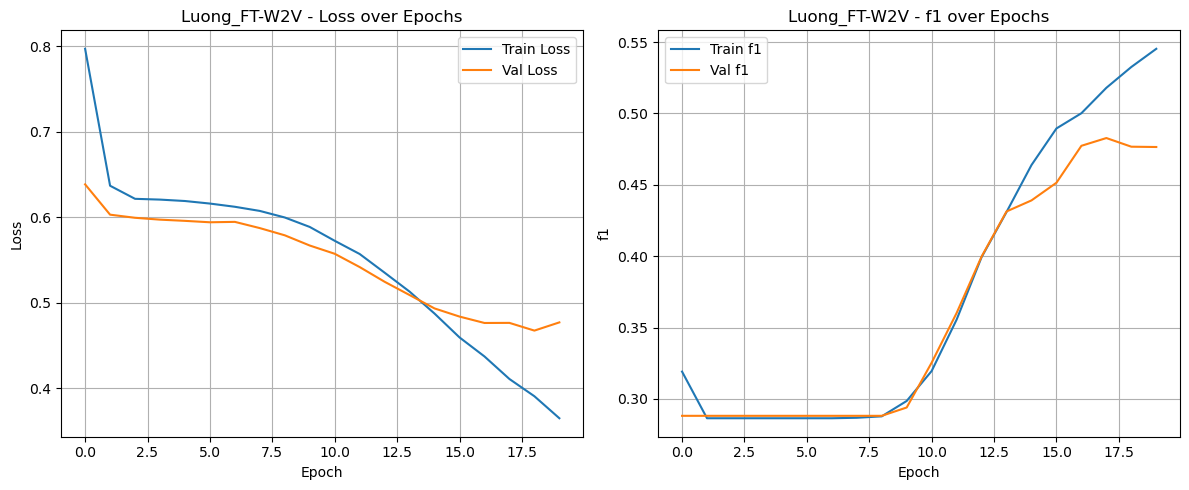

📈 Training history saved to: plots/saved/Luong_FT-W2V_plot.png


In [48]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - Luong_FT-W2V
Accuracy  : 0.8161
Precision : 0.5067
Recall    : 0.4634
F1 Score  : 0.4765


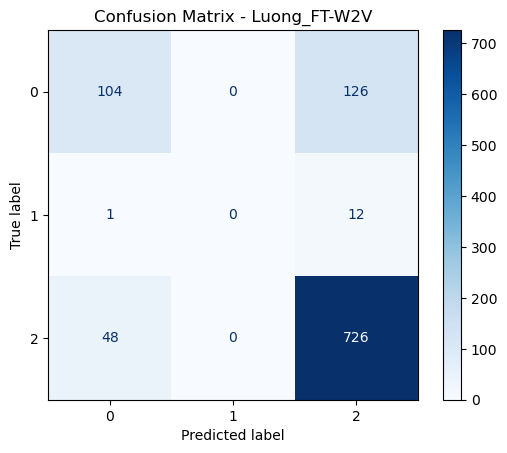

📌 Confusion matrix saved to: plots/saved/Luong_FT-W2V_csmtx.png


In [49]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [50]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 1.39 ms


In [51]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# DotProduct + FE

In [53]:
model_name='Luong_FE'

In [54]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 0.8085, F1: 0.2953 | Val_Loss: 0.6504, Val_F1: 0.2881
Epoch 02 | Loss: 0.6432, F1: 0.2864 | Val_Loss: 0.6024, Val_F1: 0.2881
Epoch 03 | Loss: 0.6231, F1: 0.2864 | Val_Loss: 0.5957, Val_F1: 0.2881
Epoch 04 | Loss: 0.6208, F1: 0.2864 | Val_Loss: 0.5946, Val_F1: 0.2881
Epoch 05 | Loss: 0.6150, F1: 0.2864 | Val_Loss: 0.5914, Val_F1: 0.2881
Epoch 06 | Loss: 0.6115, F1: 0.2864 | Val_Loss: 0.5897, Val_F1: 0.2881
Epoch 07 | Loss: 0.6052, F1: 0.2867 | Val_Loss: 0.5861, Val_F1: 0.2881
Epoch 08 | Loss: 0.5985, F1: 0.2918 | Val_Loss: 0.5844, Val_F1: 0.2881
Epoch 09 | Loss: 0.5918, F1: 0.2959 | Val_Loss: 0.5802, Val_F1: 0.2907
Epoch 10 | Loss: 0.5837, F1: 0.3129 | Val_Loss: 0.5779, Val_F1: 0.2964
Epoch 11 | Loss: 0.5775, F1: 0.3272 | Val_Loss: 0.5755, Val_F1: 0.3146
Epoch 12 | Loss: 0.5679, F1: 0.3465 | Val_Loss: 0.5736, Val_F1: 0.3103
Epoch 13 | Loss: 0.5619, F1: 0.3619 | Val_Loss: 0.5736, Val_F1: 0.3533
Epoch 14 | Loss: 0.5532, F1: 0.3819 | Val_Loss: 0.5705, Val_F1: 0.3306
Epoch 

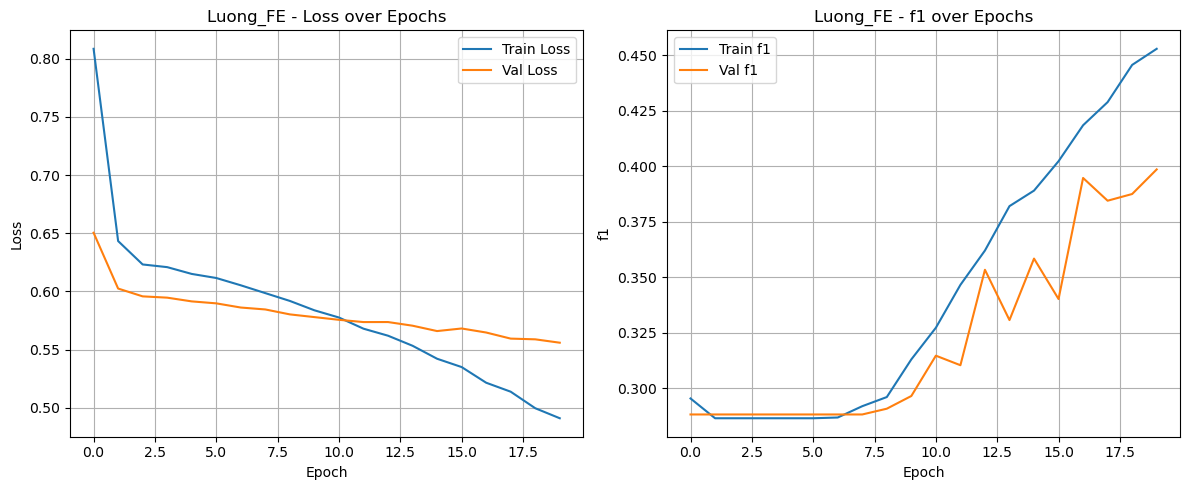

📈 Training history saved to: plots/saved/Luong_FE_plot.png


In [55]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - Luong_FE
Accuracy  : 0.7778
Precision : 0.4641
Recall    : 0.3936
F1 Score  : 0.3985


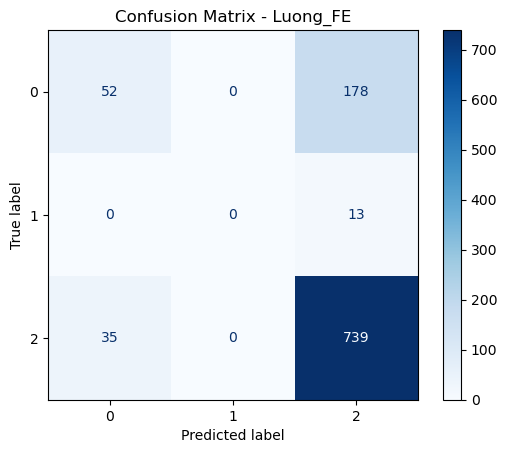

📌 Confusion matrix saved to: plots/saved/Luong_FE_csmtx.png


In [56]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [57]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 2.02 ms


In [58]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# Scaled-dotProduct + FT-W2V

In [60]:
model_name='scaled-dot_FT-W2V'

In [61]:
from transformer_model.attention import ScaledDotProductAttention
attention = ScaledDotProductAttention(hidden_dim=HIDDEN_DIM)

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 0.8324, F1: 0.3184 | Val_Loss: 0.6503, Val_F1: 0.2881
Epoch 02 | Loss: 0.6411, F1: 0.2864 | Val_Loss: 0.6048, Val_F1: 0.2881
Epoch 03 | Loss: 0.6227, F1: 0.2864 | Val_Loss: 0.5978, Val_F1: 0.2881
Epoch 04 | Loss: 0.6194, F1: 0.2864 | Val_Loss: 0.5965, Val_F1: 0.2881
Epoch 05 | Loss: 0.6150, F1: 0.2864 | Val_Loss: 0.5947, Val_F1: 0.2881
Epoch 06 | Loss: 0.6134, F1: 0.2864 | Val_Loss: 0.5922, Val_F1: 0.2881
Epoch 07 | Loss: 0.6088, F1: 0.2864 | Val_Loss: 0.5884, Val_F1: 0.2881
Epoch 08 | Loss: 0.6040, F1: 0.2867 | Val_Loss: 0.5831, Val_F1: 0.2881
Epoch 09 | Loss: 0.5969, F1: 0.2893 | Val_Loss: 0.5748, Val_F1: 0.2912
Epoch 10 | Loss: 0.5838, F1: 0.3015 | Val_Loss: 0.5647, Val_F1: 0.2942
Epoch 11 | Loss: 0.5692, F1: 0.3257 | Val_Loss: 0.5538, Val_F1: 0.3342
Epoch 12 | Loss: 0.5507, F1: 0.3588 | Val_Loss: 0.5401, Val_F1: 0.3588
Epoch 13 | Loss: 0.5318, F1: 0.4040 | Val_Loss: 0.5339, Val_F1: 0.3740
Epoch 14 | Loss: 0.5108, F1: 0.4339 | Val_Loss: 0.5194, Val_F1: 0.3971
Epoch 

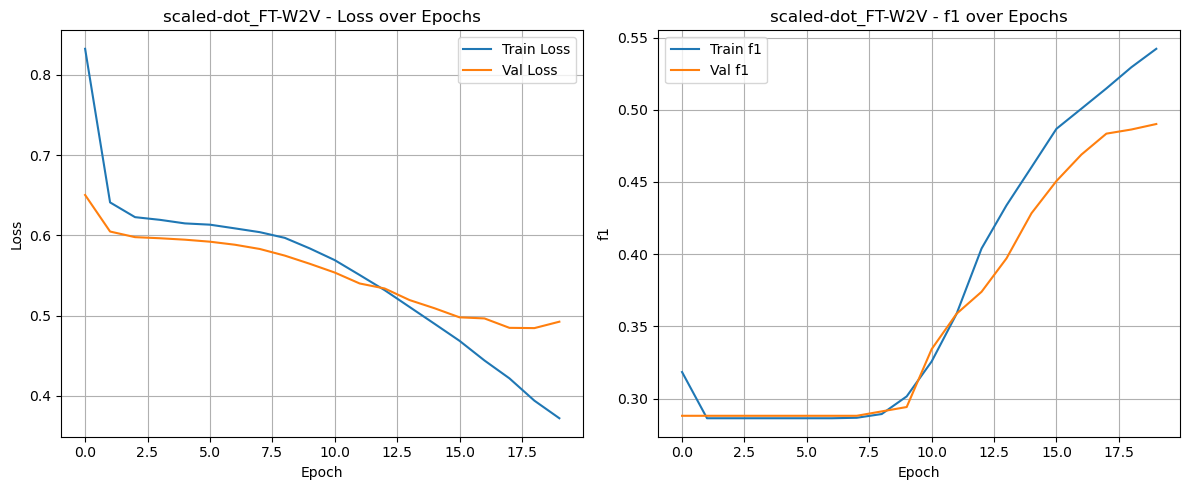

📈 Training history saved to: plots/saved/scaled-dot_FT-W2V_plot.png


In [62]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - scaled-dot_FT-W2V
Accuracy  : 0.8004
Precision : 0.4829
Recall    : 0.4983
F1 Score  : 0.4901


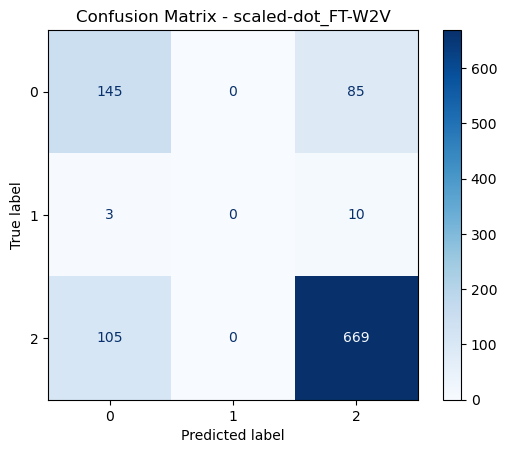

📌 Confusion matrix saved to: plots/saved/scaled-dot_FT-W2V_csmtx.png


In [63]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [64]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 0.81 ms


In [65]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# Scaled-dotProduct + FE

In [67]:
model_name='scaled-dot_FE'

In [68]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 0.9198, F1: 0.3001 | Val_Loss: 0.6878, Val_F1: 0.2881
Epoch 02 | Loss: 0.6598, F1: 0.2864 | Val_Loss: 0.6113, Val_F1: 0.2881
Epoch 03 | Loss: 0.6277, F1: 0.2864 | Val_Loss: 0.5997, Val_F1: 0.2881
Epoch 04 | Loss: 0.6232, F1: 0.2864 | Val_Loss: 0.5962, Val_F1: 0.2881
Epoch 05 | Loss: 0.6189, F1: 0.2864 | Val_Loss: 0.5940, Val_F1: 0.2881
Epoch 06 | Loss: 0.6152, F1: 0.2864 | Val_Loss: 0.5915, Val_F1: 0.2881
Epoch 07 | Loss: 0.6064, F1: 0.2864 | Val_Loss: 0.5881, Val_F1: 0.2881
Epoch 08 | Loss: 0.5999, F1: 0.2870 | Val_Loss: 0.5857, Val_F1: 0.2881
Epoch 09 | Loss: 0.5909, F1: 0.2921 | Val_Loss: 0.5820, Val_F1: 0.2907
Epoch 10 | Loss: 0.5837, F1: 0.3071 | Val_Loss: 0.5821, Val_F1: 0.3063
Epoch 11 | Loss: 0.5767, F1: 0.3249 | Val_Loss: 0.5774, Val_F1: 0.3069
Epoch 12 | Loss: 0.5674, F1: 0.3485 | Val_Loss: 0.5752, Val_F1: 0.3196
Epoch 13 | Loss: 0.5584, F1: 0.3634 | Val_Loss: 0.5730, Val_F1: 0.3163
Epoch 14 | Loss: 0.5505, F1: 0.3737 | Val_Loss: 0.5700, Val_F1: 0.3361
Epoch 

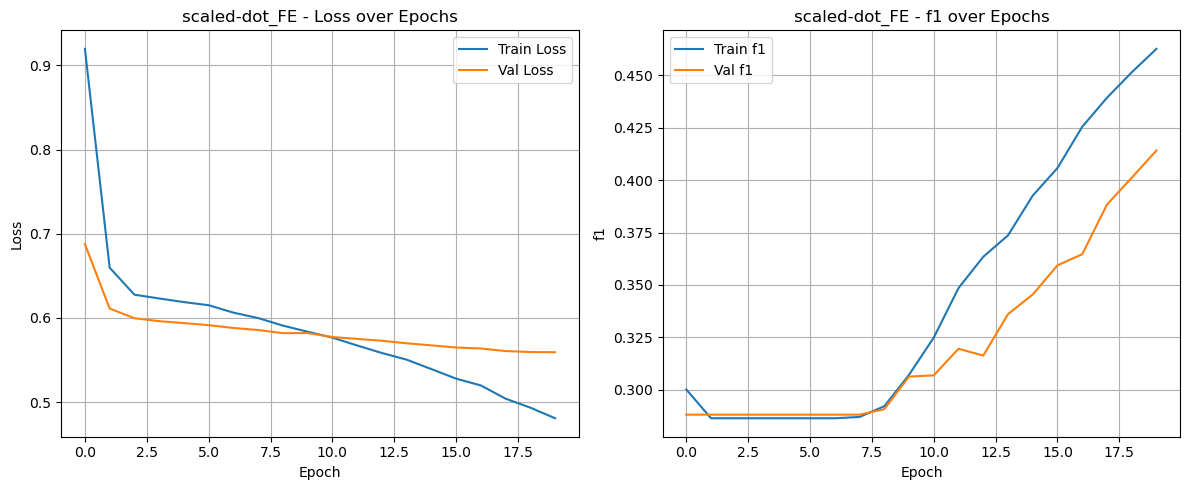

📈 Training history saved to: plots/saved/scaled-dot_FE_plot.png


In [69]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - scaled-dot_FE
Accuracy  : 0.7797
Precision : 0.4590
Recall    : 0.4067
F1 Score  : 0.4142


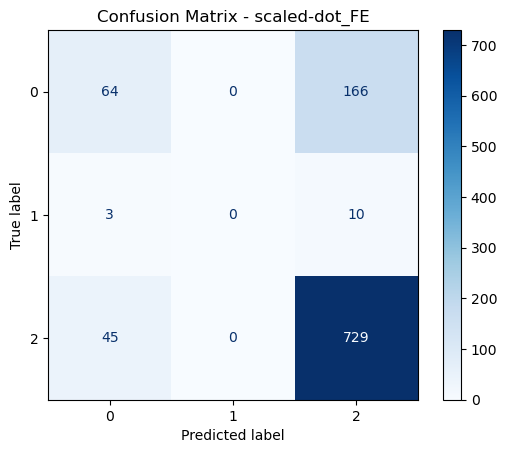

📌 Confusion matrix saved to: plots/saved/scaled-dot_FE_csmtx.png


In [70]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [71]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 1.69 ms


In [72]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# result

In [74]:
main_result

{'model_name': ['bahdanau_FT-W2V',
  'bahdanau_FE',
  'Luong_FT-W2V',
  'Luong_FE',
  'scaled-dot_FT-W2V',
  'scaled-dot_FE'],
 'Accuracy': [0.8062930186823992,
  0.7413962635201573,
  0.816125860373648,
  0.7777777777777778,
  0.80039331366765,
  0.7797443461160275],
 'Precision': [0.4875985308076431,
  0.4064932016877097,
  0.5066721132897604,
  0.46410826844642195,
  0.4829256599686829,
  0.45898447776900814],
 'Recall': [0.47537729843088794,
  0.38685540950455005,
  0.46338613638916976,
  0.39362243942628167,
  0.49825862262667114,
  0.4067071115604988],
 'F1': [0.48011816364450216,
  0.3893657218216681,
  0.476509275464889,
  0.39848220059931977,
  0.49012502232381233,
  0.41421434600331813],
 'Train_Time': [33138.60368728638,
  33066.68448448181,
  33831.416845321655,
  32965.44671058655,
  33675.968170166016,
  33270.907402038574],
 'Infer_Time': [3.004789352416992,
  1.02996826171875,
  1.3854503631591797,
  2.0227432250976562,
  0.8068084716796875,
  1.6913414001464844]}

(<Figure size 1800x1000 with 3 Axes>,
 (<Axes: title={'center': 'Model Performance Metrics'}, ylabel='Value'>,
  <Axes: title={'center': 'Model Training and Inference Times'}, xlabel='Model', ylabel='Training Time (seconds)'>,
  <Axes: ylabel='Inference Time (seconds)'>))

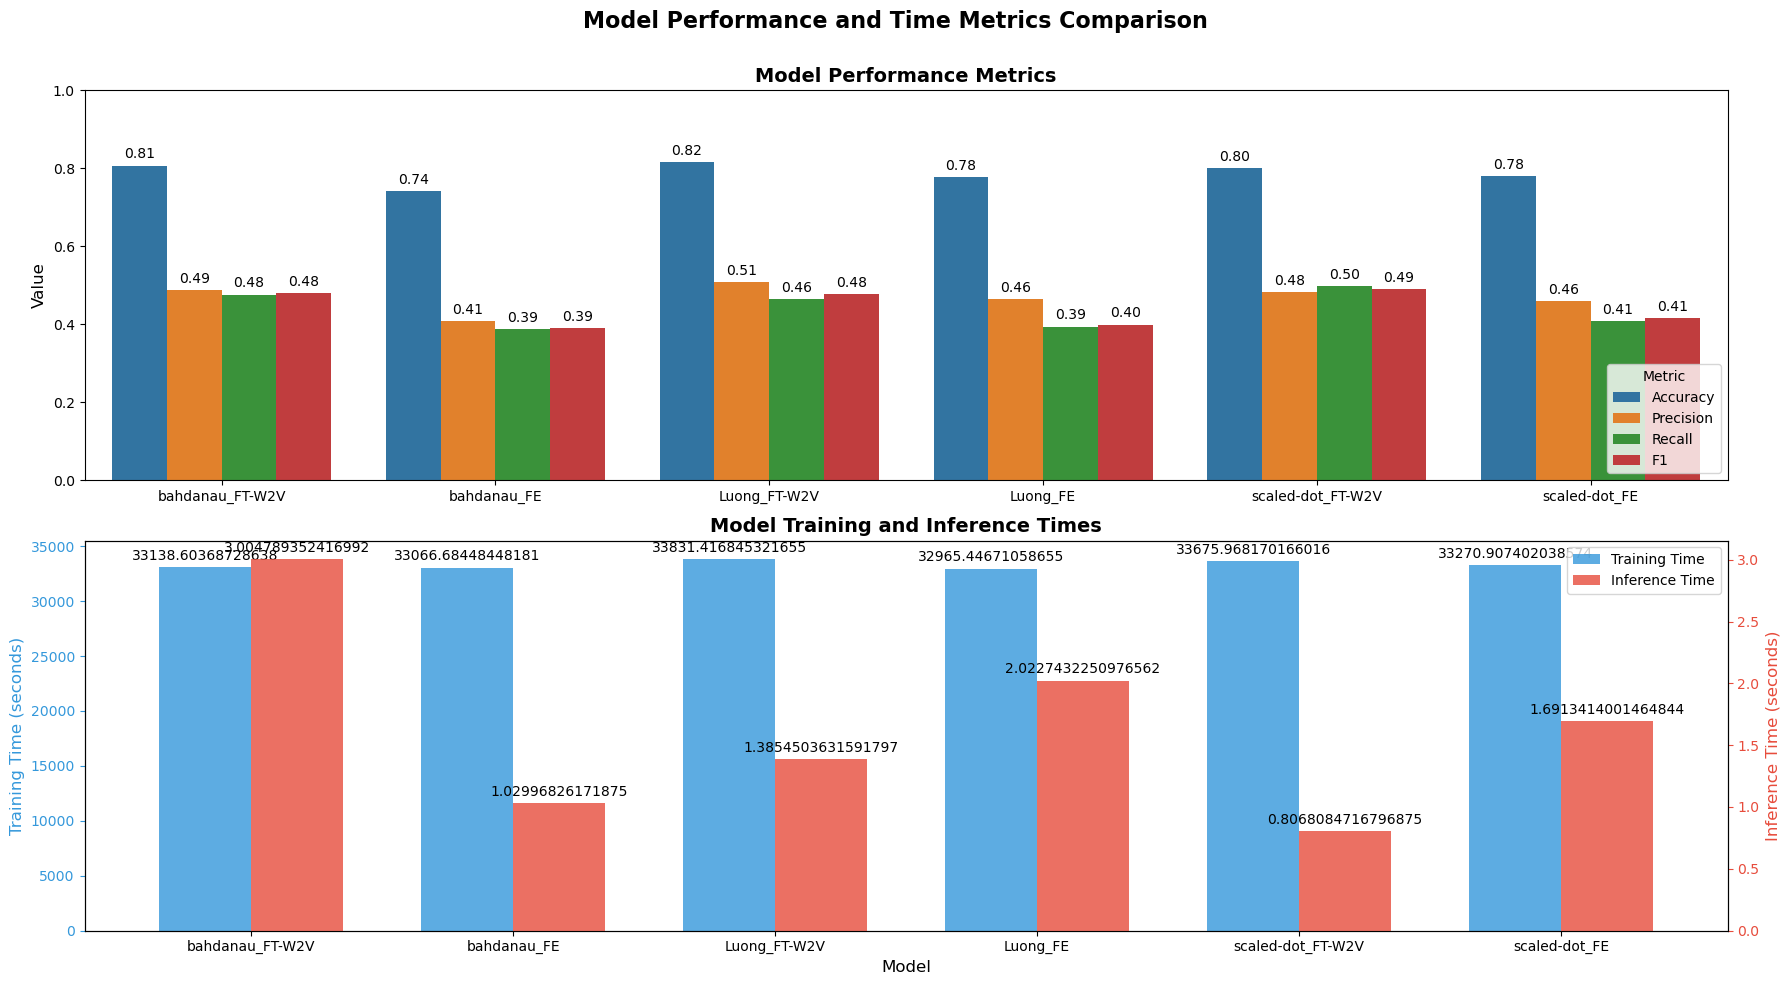

In [75]:
from plots.time_metric import plot_all_model_metrics

plot_all_model_metrics(main_result)

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Model Performance Metrics Comparison'}, xlabel='Model', ylabel='Value'>)

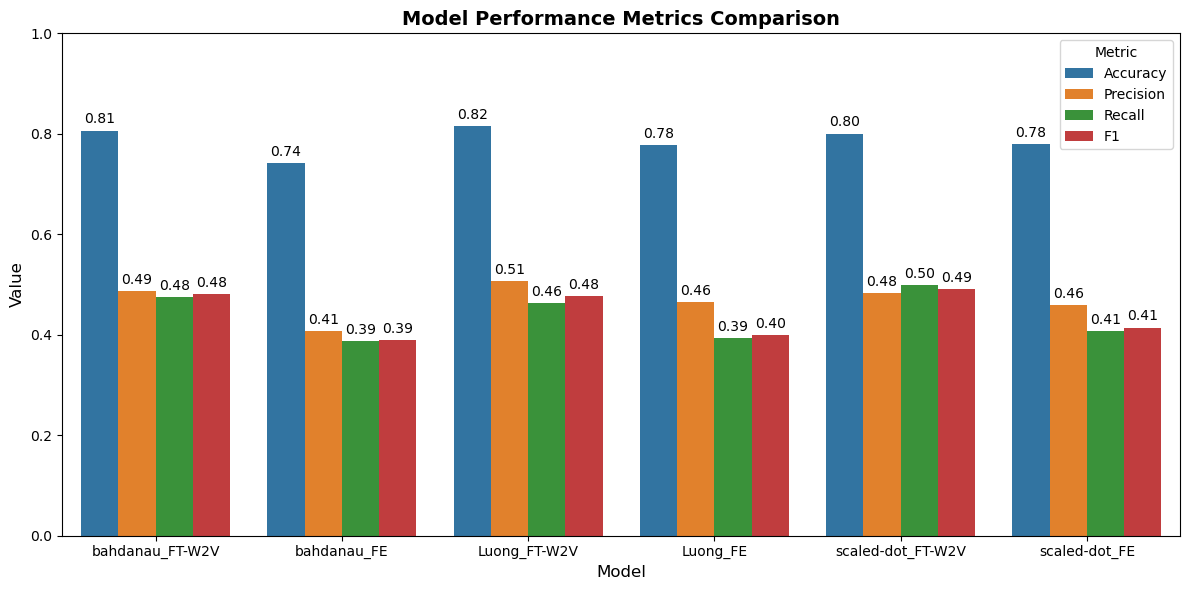

In [76]:
from plots.time_metric import plot_performance_metrics
plot_performance_metrics(main_result)

In [77]:
# AdditiveAttention + FT-W2V